<center><h1>Luo_Xiao_HW5</h1></center>
<br>
<br>

Name: Xiao Luo
<br>
Github Username: xluo23
<br>
USC ID: 2392693288

## 1. Decision Trees as Interpretable Models

Import packages

In [53]:
import pandas as pd
from sklearn import tree
from matplotlib import pyplot as plt

### (a) Obtain Data

Get the Accute Inamations Data Set

In [57]:
df =  pd.read_csv('data/diagnosis.data', sep="\t", encoding='utf-16',header=None)
df.columns = ['Temperature','Nausea','Lumbar pain','Urine pushing','Micturition pains','Urethra burning','d1_Inflammation','d2_Nephritis']
df['Temperature'] = df['Temperature'].str.replace(',','.')
df['Temperature'] = pd.to_numeric(df['Temperature'])
for i in df.columns[1:]: df[i] = df[i].map({'yes':1, 'no':0})
df

Temperature  Nausea  Lumbar pain  Urine pushing  Micturition pains  \
0           35.5       0            1              0                  0   
1           35.9       0            0              1                  1   
2           35.9       0            1              0                  0   
3           36.0       0            0              1                  1   
4           36.0       0            1              0                  0   
..           ...     ...          ...            ...                ...   
115         41.4       0            1              1                  0   
116         41.5       0            0              0                  0   
117         41.5       1            1              0                  1   
118         41.5       0            1              1                  0   
119         41.5       0            1              1                  0   

     Urethra burning  d1_Inflammation  d2_Nephritis  
0                  0                0             0  
1                  1                1             0  
2                  0                0             0  
3                  1                1             0  
4                  0                0             0  
..               ...              ...           ...  
115                1                0             1  
116                0                0             0  
117                0                0             1  
118                1                0             1  
119                1                0             1  

[120 rows x 8 columns]

### (b) Build a decision tree

|--- feature_0 <= 37.95
|   |--- feature_2 <= 0.50
|   |   |--- class: 1
|   |--- feature_2 >  0.50
|   |   |--- class: 0
|--- feature_0 >  37.95
|   |--- feature_2 <= 0.50
|   |   |--- class: 0
|   |--- feature_2 >  0.50
|   |   |--- feature_4 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_4 >  0.50
|   |   |   |--- feature_3 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_3 >  0.50
|   |   |   |   |--- class: 0



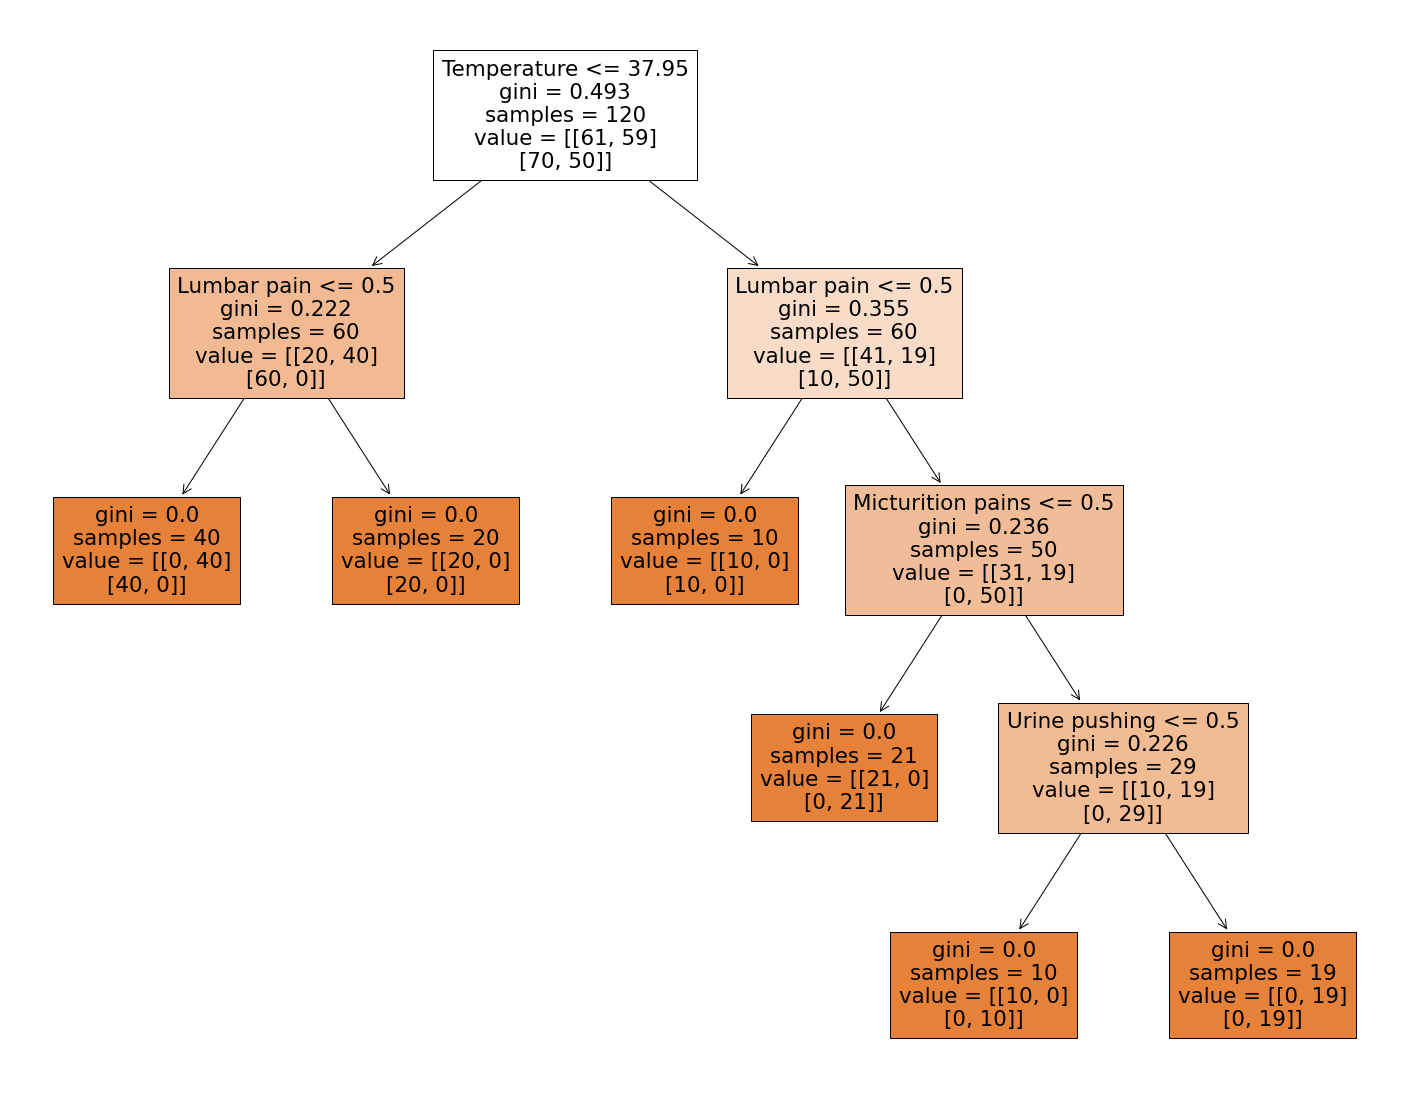

In [336]:
X = df[['Temperature','Nausea','Lumbar pain','Urine pushing','Micturition pains','Urethra burning']]
y = df[['d1_Inflammation','d2_Nephritis']]

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)
text_representation = tree.export_text(clf)
print(text_representation)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names= list(X.columns),  
                   class_names= list(y.columns),
                   filled=True)

### (c) Convert the decision rules

In [62]:
def tree_to_pseudo(tree, feature_names):
	"""
	Outputs a decision tree model as if/then pseudocode
	
	Parameters:
	-----------
	tree: decision tree model
		The decision tree to represent as pseudocode
	feature_names: list
		The feature names of the dataset used for building the decision tree
	"""

	left = tree.tree_.children_left
	right = tree.tree_.children_right
	threshold = tree.tree_.threshold
	features = [feature_names[i] for i in tree.tree_.feature]
	value = tree.tree_.value

	def recurse(left, right, threshold, features, node, depth=0):
		indent = "  " * depth
		if (threshold[node] != -2):
			print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
			if left[node] != -1:
				recurse (left, right, threshold, features, left[node], depth+1)
				print(indent,"} else {")
				if right[node] != -1:
					recurse (left, right, threshold, features, right[node], depth+1)
				print(indent,"}")
		else:
			print(indent,"return " + str(value[node]))

	recurse(left, right, threshold, features, 0)

tree_to_pseudo(clf, list(X.columns))

 if ( Temperature <= 37.95000076293945 ) {
   if ( Lumbar pain <= 0.5 ) {
     return [[ 0. 40.]
 [40.  0.]]
   } else {
     return [[20.  0.]
 [20.  0.]]
   }
 } else {
   if ( Lumbar pain <= 0.5 ) {
     return [[10.  0.]
 [10.  0.]]
   } else {
     if ( Nausea <= 0.5 ) {
       return [[21.  0.]
 [ 0. 21.]]
     } else {
       if ( Urine pushing <= 0.5 ) {
         return [[10.  0.]
 [ 0. 10.]]
       } else {
         return [[ 0. 19.]
 [ 0. 19.]]
       }
     }
   }
 }


### (d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability

Number of nodes in the last tree is: 1 with ccp_alpha: 0.204236111111111
Based on the scores, the minimum decision tree has 3 nodes, alpha = 0.11111111


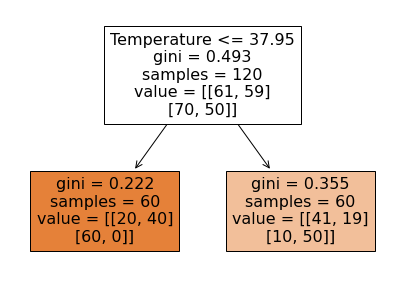

In [362]:
clf = tree.DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# print(ccp_alphas)
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)

print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]))

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# print(ccp_alphas)
node_counts = [clf.tree_.node_count for clf in clfs]
# print(node_counts)
scores = [clf.score(X, y) for clf in clfs]
# print(scores)

print("Based on the scores, the minimum decision tree has 3 nodes, alpha = 0.11111111")

min = tree.DecisionTreeClassifier(ccp_alpha = ccp_alphas[-1])
min.fit(X, y)
fig = plt.figure(figsize=(7,5))
_ = tree.plot_tree(min, 
                   feature_names= list(X.columns),  
                   class_names= list(y.columns),
                   filled=True)

## https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [112]:
df2 =  pd.read_csv('data/communities.data', sep="\t", encoding='utf-8',header=None)
df2 = df2[0].str.split(',', expand=True)

df2 = df2.iloc[:, 5:]  # drop first 5 non-predictive features
df2.columns = ['population','householdsize','racepctblack','racePctWhite','racePctAsian',
            'racePctHisp','agePct12t21','agePct12t29','agePct16t24','agePct65up','numbUrban','pctUrban',
            'medIncome','pctWWage','pctWFarmSelf','pctWInvInc','pctWSocSec','pctWPubAsst',
            'pctWRetire','medFamInc','perCapInc','whitePerCap','blackPerCap','indianPerCap',
            'AsianPerCap','OtherPerCap','HispPerCap','NumUnderPov','PctPopUnderPov','PctLess9thGrade',
            'PctNotHSGrad','PctBSorMore','PctUnemployed','PctEmploy','PctEmplManu','PctEmplProfServ',
            'PctOccupManu','PctOccupMgmtProf','MalePctDivorce','MalePctNevMarr','FemalePctDiv',
            'TotalPctDiv','PersPerFam','PctFam2Par','PctKids2Par','PctYoungKids2Par','PctTeen2Par',
            'PctWorkMomYoungKids','PctWorkMom','NumIlleg','PctIlleg','NumImmig','PctImmigRecent',
            'PctImmigRec5','PctImmigRec8','PctImmigRec10','PctRecentImmig','PctRecImmig5','PctRecImmig8',
            'PctRecImmig10','PctSpeakEnglOnly','PctNotSpeakEnglWell','PctLargHouseFam','PctLargHouseOccup',
            'PersPerOccupHous','PersPerOwnOccHous','PersPerRentOccHous','PctPersOwnOccup','PctPersDenseHous',
            'PctHousLess3BR','MedNumBR','HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded',
            'PctVacMore6Mos','MedYrHousBuilt','PctHousNoPhone','PctWOFullPlumb','OwnOccLowQuart','OwnOccMedVal',
            'OwnOccHiQuart','RentLowQ','RentMedian','RentHighQ','MedRent','MedRentPctHousInc','MedOwnCostPctInc',
            'MedOwnCostPctIncNoMtg','NumInShelters','NumStreet','PctForeignBorn','PctBornSameState','PctSameHouse85',
            'PctSameCity85','PctSameState85','LemasSwornFT','LemasSwFTPerPop','LemasSwFTFieldOps','LemasSwFTFieldPerPop',
            'LemasTotalReq','LemasTotReqPerPop','PolicReqPerOffic','PolicPerPop','RacialMatchCommPol','PctPolicWhite',
            'PctPolicBlack','PctPolicHisp','PctPolicAsian','PctPolicMinor','OfficAssgnDrugUnits','NumKindsDrugsSeiz',
            'PolicAveOTWorked','LandArea','PopDens','PctUsePubTrans','PolicCars','PolicOperBudg','LemasPctPolicOnPatr',
            'LemasGangUnitDeploy','LemasPctOfficDrugUn','PolicBudgPerPop','ViolentCrimesPerPop']
df2

train_set = df2.head(1495)
print("The training set:")
display(train_set)


test_set = df2[1495:]
print("The test set:")
display(test_set)


The training set:


population householdsize racepctblack racePctWhite racePctAsian  \
0          0.19          0.33         0.02          0.9         0.12   
1             0          0.16         0.12         0.74         0.45   
2             0          0.42         0.49         0.56         0.17   
3          0.04          0.77            1         0.08         0.12   
4          0.01          0.55         0.02         0.95         0.09   
...         ...           ...          ...          ...          ...   
1490          0          0.59         0.01         0.69            1   
1491       0.16          0.62         0.03         0.74         0.48   
1492       0.01          0.36         0.95         0.24         0.03   
1493       0.06          0.53         0.01         0.98         0.05   
1494       0.05          0.43         0.08         0.65         0.12   

     racePctHisp agePct12t21 agePct12t29 agePct16t24 agePct65up  ... LandArea  \
0           0.17        0.34        0.47        0.29       0.32  ...     0.12   
1           0.07        0.26        0.59        0.35       0.27  ...     0.02   
2           0.04        0.39        0.47        0.28       0.32  ...     0.01   
3            0.1        0.51         0.5        0.34       0.21  ...     0.02   
4           0.05        0.38        0.38        0.23       0.36  ...     0.04   
...          ...         ...         ...         ...        ...  ...      ...   
1490        0.07        0.41        0.28        0.23       0.57  ...     0.02   
1491        0.42        0.44        0.57         0.4       0.25  ...     0.07   
1492        0.01        0.44        0.42        0.27       0.63  ...     0.03   
1493        0.01         0.4         0.4        0.24       0.29  ...     0.08   
1494           1        0.37        0.52        0.33       0.44  ...        0   

     PopDens PctUsePubTrans PolicCars PolicOperBudg LemasPctPolicOnPatr  \
0       0.26            0.2      0.06          0.04                 0.9   
1       0.12           0.45         ?             ?                   ?   
2       0.21           0.02         ?             ?                   ?   
3       0.39           0.28         ?             ?                   ?   
4       0.09           0.02         ?             ?                   ?   
...      ...            ...       ...           ...                 ...   
1490    0.14           0.22         ?             ?                   ?   
1491     0.4           0.14      0.07          0.05                0.85   
1492    0.12           0.01         ?             ?                   ?   
1493    0.15           0.02         ?             ?                   ?   
1494       1              1         0          0.01                0.77   

     LemasGangUnitDeploy LemasPctOfficDrugUn PolicBudgPerPop  \
0                    0.5                0.32            0.14   
1                      ?                   0               ?   
2                      ?                   0               ?   
3                      ?                   0               ?   
4                      ?                   0               ?   
...                  ...                 ...             ...   
1490                   ?                   0               ?   
1491                 0.5                0.61            0.19   
1492                   ?                   0               ?   
1493                   ?                   0               ?   
1494                   0                0.51            0.18   

     ViolentCrimesPerPop  
0                    0.2  
1                   0.67  
2                   0.43  
3                   0.12  
4                   0.03  
...                  ...  
1490                0.03  
1491                 0.2  
1492                 0.3  
1493                0.03  
1494                0.23  

[1495 rows x 123 columns]

The test set:


population householdsize racepctblack racePctWhite racePctAsian  \
1495          0           0.2         0.03         0.91         0.23   
1496          0          0.55         0.13         0.78         0.15   
1497          0          0.52         0.04         0.59         0.05   
1498       0.04          0.51         0.07         0.92         0.09   
1499       0.03          0.59          0.2         0.75         0.19   
...         ...           ...          ...          ...          ...   
1989       0.01           0.4          0.1         0.87         0.12   
1990       0.05          0.96         0.46         0.28         0.83   
1991       0.16          0.37         0.25         0.69         0.04   
1992       0.08          0.51         0.06         0.87         0.22   
1993        0.2          0.78         0.14         0.46         0.24   

     racePctHisp agePct12t21 agePct12t29 agePct16t24 agePct65up  ... LandArea  \
1495        0.05        0.15        0.19        0.09       0.42  ...     0.01   
1496        0.36        0.48        0.53         0.3        0.1  ...     0.01   
1497        0.62        0.84        0.78        0.75       0.43  ...     0.01   
1498        0.03        0.38        0.47        0.27       0.35  ...     0.06   
1499         0.1        0.38        0.62        0.35       0.11  ...     0.03   
...          ...         ...         ...         ...        ...  ...      ...   
1989        0.16        0.43        0.51        0.35        0.3  ...     0.01   
1990        0.32        0.69        0.86        0.73       0.14  ...     0.02   
1991        0.25        0.35         0.5        0.31       0.54  ...     0.08   
1992         0.1        0.58        0.74        0.63       0.41  ...     0.03   
1993        0.77         0.5        0.62         0.4       0.17  ...     0.11   

     PopDens PctUsePubTrans PolicCars PolicOperBudg LemasPctPolicOnPatr  \
1495    0.23           0.73         ?             ?                   ?   
1496    0.18           0.02         ?             ?                   ?   
1497    0.18              0         ?             ?                   ?   
1498    0.13           0.16         ?             ?                   ?   
1499    0.23           0.06         ?             ?                   ?   
...      ...            ...       ...           ...                 ...   
1989    0.28           0.05         ?             ?                   ?   
1990    0.37            0.2         ?             ?                   ?   
1991    0.32           0.18      0.08          0.06                0.78   
1992    0.38           0.33      0.02          0.02                0.79   
1993     0.3           0.05      0.08          0.04                0.73   

     LemasGangUnitDeploy LemasPctOfficDrugUn PolicBudgPerPop  \
1495                   ?                   0               ?   
1496                   ?                   0               ?   
1497                   ?                   0               ?   
1498                   ?                   0               ?   
1499                   ?                   0               ?   
...                  ...                 ...             ...   
1989                   ?                   0               ?   
1990                   ?                   0               ?   
1991                   0                0.91            0.28   
1992                   0                0.22            0.18   
1993                 0.5                   1            0.13   

     ViolentCrimesPerPop  
1495                0.12  
1496                0.11  
1497                0.12  
1498                0.06  
1499                0.12  
...                  ...  
1989                0.09  
1990                0.45  
1991                0.23  
1992                0.19  
1993                0.48  

[499 rows x 123 columns]

### (b) Missing values

In [225]:
from sklearn.impute import SimpleImputer

for column in df2:
    df2[column] = pd.to_numeric(df2[column],errors='coerce')
    
imp = SimpleImputer(strategy='mean')
imp_data = imp.fit_transform(df2)
imp_df2 = pd.DataFrame(imp_data)
imp_df2.columns = ['population','householdsize','racepctblack','racePctWhite','racePctAsian',
            'racePctHisp','agePct12t21','agePct12t29','agePct16t24','agePct65up','numbUrban','pctUrban',
            'medIncome','pctWWage','pctWFarmSelf','pctWInvInc','pctWSocSec','pctWPubAsst',
            'pctWRetire','medFamInc','perCapInc','whitePerCap','blackPerCap','indianPerCap',
            'AsianPerCap','OtherPerCap','HispPerCap','NumUnderPov','PctPopUnderPov','PctLess9thGrade',
            'PctNotHSGrad','PctBSorMore','PctUnemployed','PctEmploy','PctEmplManu','PctEmplProfServ',
            'PctOccupManu','PctOccupMgmtProf','MalePctDivorce','MalePctNevMarr','FemalePctDiv',
            'TotalPctDiv','PersPerFam','PctFam2Par','PctKids2Par','PctYoungKids2Par','PctTeen2Par',
            'PctWorkMomYoungKids','PctWorkMom','NumIlleg','PctIlleg','NumImmig','PctImmigRecent',
            'PctImmigRec5','PctImmigRec8','PctImmigRec10','PctRecentImmig','PctRecImmig5','PctRecImmig8',
            'PctRecImmig10','PctSpeakEnglOnly','PctNotSpeakEnglWell','PctLargHouseFam','PctLargHouseOccup',
            'PersPerOccupHous','PersPerOwnOccHous','PersPerRentOccHous','PctPersOwnOccup','PctPersDenseHous',
            'PctHousLess3BR','MedNumBR','HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded',
            'PctVacMore6Mos','MedYrHousBuilt','PctHousNoPhone','PctWOFullPlumb','OwnOccLowQuart','OwnOccMedVal',
            'OwnOccHiQuart','RentLowQ','RentMedian','RentHighQ','MedRent','MedRentPctHousInc','MedOwnCostPctInc',
            'MedOwnCostPctIncNoMtg','NumInShelters','NumStreet','PctForeignBorn','PctBornSameState','PctSameHouse85',
            'PctSameCity85','PctSameState85','LemasSwornFT','LemasSwFTPerPop','LemasSwFTFieldOps','LemasSwFTFieldPerPop',
            'LemasTotalReq','LemasTotReqPerPop','PolicReqPerOffic','PolicPerPop','RacialMatchCommPol','PctPolicWhite',
            'PctPolicBlack','PctPolicHisp','PctPolicAsian','PctPolicMinor','OfficAssgnDrugUnits','NumKindsDrugsSeiz',
            'PolicAveOTWorked','LandArea','PopDens','PctUsePubTrans','PolicCars','PolicOperBudg','LemasPctPolicOnPatr',
            'LemasGangUnitDeploy','LemasPctOfficDrugUn','PolicBudgPerPop','ViolentCrimesPerPop']

display(imp_df2)
X = imp_df2.iloc[:, :-1] 
y = imp_df2.iloc[:, -1]

train_set = imp_df2.head(1495)
test_set = imp_df2[1495:]

X_train = train_set.iloc[:, :-1] 
y_train = train_set.iloc[:, -1]
X_test = test_set.iloc[:, :-1] 
y_test = test_set.iloc[:, -1]

population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0           0.19           0.33          0.02          0.90          0.12   
1           0.00           0.16          0.12          0.74          0.45   
2           0.00           0.42          0.49          0.56          0.17   
3           0.04           0.77          1.00          0.08          0.12   
4           0.01           0.55          0.02          0.95          0.09   
...          ...            ...           ...           ...           ...   
1989        0.01           0.40          0.10          0.87          0.12   
1990        0.05           0.96          0.46          0.28          0.83   
1991        0.16           0.37          0.25          0.69          0.04   
1992        0.08           0.51          0.06          0.87          0.22   
1993        0.20           0.78          0.14          0.46          0.24   

      racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0            0.17         0.34         0.47         0.29        0.32  ...   
1            0.07         0.26         0.59         0.35        0.27  ...   
2            0.04         0.39         0.47         0.28        0.32  ...   
3            0.10         0.51         0.50         0.34        0.21  ...   
4            0.05         0.38         0.38         0.23        0.36  ...   
...           ...          ...          ...          ...         ...  ...   
1989         0.16         0.43         0.51         0.35        0.30  ...   
1990         0.32         0.69         0.86         0.73        0.14  ...   
1991         0.25         0.35         0.50         0.31        0.54  ...   
1992         0.10         0.58         0.74         0.63        0.41  ...   
1993         0.77         0.50         0.62         0.40        0.17  ...   

      LandArea  PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  \
0         0.12     0.26            0.20   0.060000       0.040000   
1         0.02     0.12            0.45   0.163103       0.076708   
2         0.01     0.21            0.02   0.163103       0.076708   
3         0.02     0.39            0.28   0.163103       0.076708   
4         0.04     0.09            0.02   0.163103       0.076708   
...        ...      ...             ...        ...            ...   
1989      0.01     0.28            0.05   0.163103       0.076708   
1990      0.02     0.37            0.20   0.163103       0.076708   
1991      0.08     0.32            0.18   0.080000       0.060000   
1992      0.03     0.38            0.33   0.020000       0.020000   
1993      0.11     0.30            0.05   0.080000       0.040000   

      LemasPctPolicOnPatr  LemasGangUnitDeploy  LemasPctOfficDrugUn  \
0                0.900000             0.500000                 0.32   
1                0.698589             0.440439                 0.00   
2                0.698589             0.440439                 0.00   
3                0.698589             0.440439                 0.00   
4                0.698589             0.440439                 0.00   
...                   ...                  ...                  ...   
1989             0.698589             0.440439                 0.00   
1990             0.698589             0.440439                 0.00   
1991             0.780000             0.000000                 0.91   
1992             0.790000             0.000000                 0.22   
1993             0.730000             0.500000                 1.00   

      PolicBudgPerPop  ViolentCrimesPerPop  
0            0.140000                 0.20  
1            0.195078                 0.67  
2            0.195078                 0.43  
3            0.195078                 0.12  
4            0.195078                 0.03  
...               ...                  ...  
1989         0.195078                 0.09  
1990         0.195078                 0.45  
1991         0.280000                 0.23  
1992         0.180000   

### (c) Plot a correlation matrix

population  householdsize  racepctblack  racePctWhite  \
population             1.000000      -0.046148      0.231178     -0.300845   
householdsize         -0.046148       1.000000     -0.067109     -0.235907   
racepctblack           0.231178      -0.067109      1.000000     -0.794389   
racePctWhite          -0.300845      -0.235907     -0.794389      1.000000   
racePctAsian           0.181603       0.201996     -0.106738     -0.270266   
...                         ...            ...           ...           ...   
PolicOperBudg          0.595543      -0.007584      0.083179     -0.114860   
LemasPctPolicOnPatr   -0.061583      -0.006426     -0.082660      0.052940   
LemasGangUnitDeploy    0.076527      -0.000280      0.010987     -0.033209   
LemasPctOfficDrugUn    0.466352      -0.094368      0.260793     -0.276234   
PolicBudgPerPop       -0.035576      -0.054562      0.022237     -0.006323   

                     racePctAsian  racePctHisp  agePct12t21  agePct12t29  \
population               0.181603     0.156218     0.006368     0.130344   
householdsize            0.201996     0.468659     0.520461     0.367338   
racepctblack            -0.106738    -0.066581     0.122338     0.153475   
racePctWhite            -0.270266    -0.444166    -0.194015    -0.266852   
racePctAsian             1.000000     0.266743    -0.025020     0.100727   
...                           ...          ...          ...          ...   
PolicOperBudg            0.067745     0.060263    -0.017679     0.012647   
LemasPctPolicOnPatr      0.032389     0.024366     0.000652     0.013327   
LemasGangUnitDeploy      0.065424     0.025956     0.011271     0.005145   
LemasPctOfficDrugUn      0.101888     0.125353     0.001301     0.117290   
PolicBudgPerPop         -0.011619     0.002234    -0.076589    -0.068575   

                     agePct16t24  agePct65up  ...  PolicAveOTWorked  LandArea  \
population              0.075596   -0.102006  ...          0.116820  0.713652   
householdsize           0.295225   -0.612666  ...          0.034583 -0.015078   
racepctblack            0.134068    0.052934  ...         -0.051876  0.149758   
racePctWhite           -0.183804    0.136483  ...         -0.026824 -0.131389   
racePctAsian            0.052761   -0.272020  ...          0.133093 -0.001084   
...                          ...         ...  ...               ...       ...   
PolicOperBudg          -0.001258   -0.026586  ...          0.115837  0.399946   
LemasPctPolicOnPatr     0.013687    0.005601  ...          0.019668 -0.067678   
LemasGangUnitDeploy    -0.001001   -0.042756  ...          0.110277  0.109830   
LemasPctOfficDrugUn     0.083180   -0.010168  ...         -0.028096  0.299632   
PolicBudgPerPop        -0.049876    0.076586  ...          0.044429 -0.113166   

                      PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  \
population           0.231897        0.270356   0.609147       0.595543   
householdsize       -0.004072       -0.051506  -0.032663      -0.007584   
racepctblack         0.095053        0.147023   0.122017       0.083179   
racePctWhite        -0.337458       -0.215636  -0.109191      -0.114860   
racePctAsian         0.389944        0.296921  -0.017992       0.067745   
...                       ...             ...        ...            ...   
PolicOperBudg        0.131075        0.171587   0.802372       1.000000   
LemasPctPolicOnPatr  0.055734        0.023457  -0.115349      -0.089736   
LemasGangUnitDeploy -0.076634       -0.082946   0.078436       0.023349   
LemasPctOfficDrugUn  0.228084        0.206644  -0.052426      -0.062677   
PolicBudgPerPop      0.067199        0.080024   0.245532       0.259342   

                     LemasPctPolicOnPatr  LemasGangUnitDeploy  \
population                     -0.061583             0.076527   
householdsize                  -0.006426            -0.000280   
racepctblack                   -0.082660             0.010987   
racePctWhite                    0.052

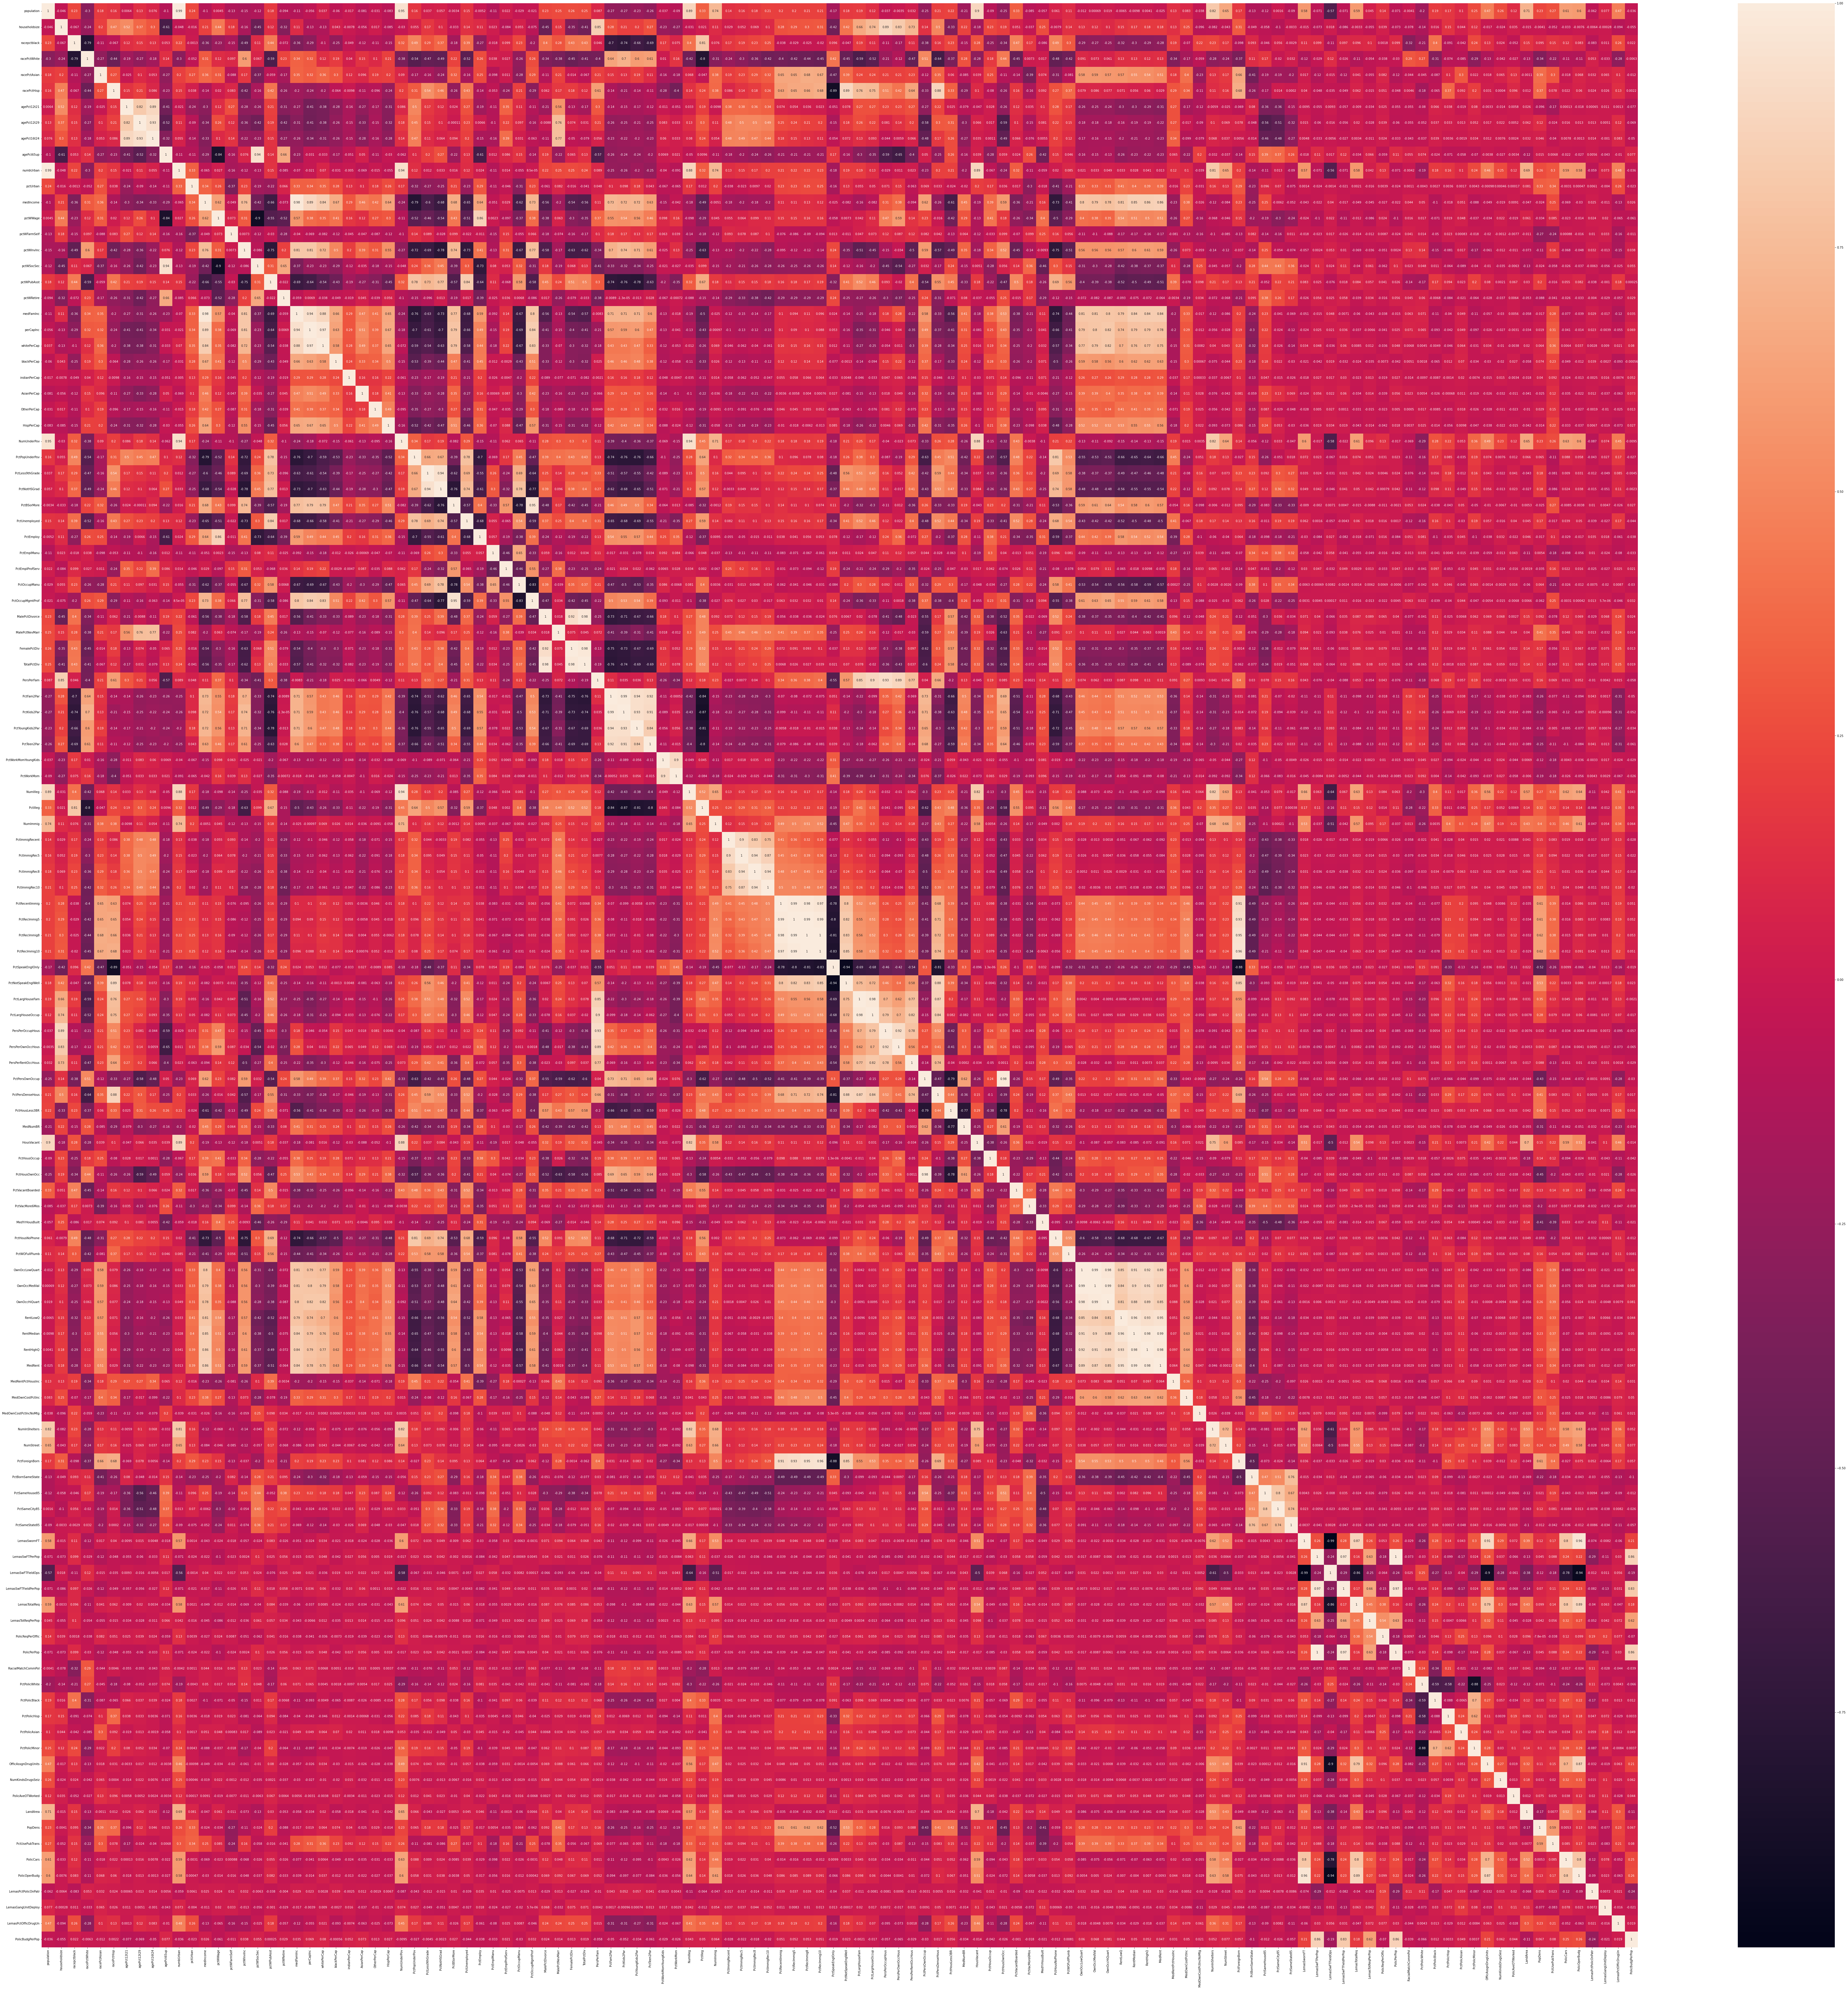

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X.corr()
display(corr)
fig, ax = plt.subplots(figsize=(122, 122))
sns.heatmap(corr, annot=True)
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [143]:
import numpy as np
s = np.std(X, axis=0)
m = np.mean(X, axis=0)
cv = s / m
cv

population             2.202950
householdsize          0.353210
racepctblack           1.410567
racePctWhite           0.323700
racePctAsian           1.358821
                         ...   
PolicOperBudg          0.729924
LemasPctPolicOnPatr    0.122301
LemasGangUnitDeploy    0.367948
LemasPctOfficDrugUn    2.554625
PolicBudgPerPop        0.337196
Length: 122, dtype: float64

### (e) Scatter plots and box plots for highest CV features

<Figure size 432x288 with 0 Axes>

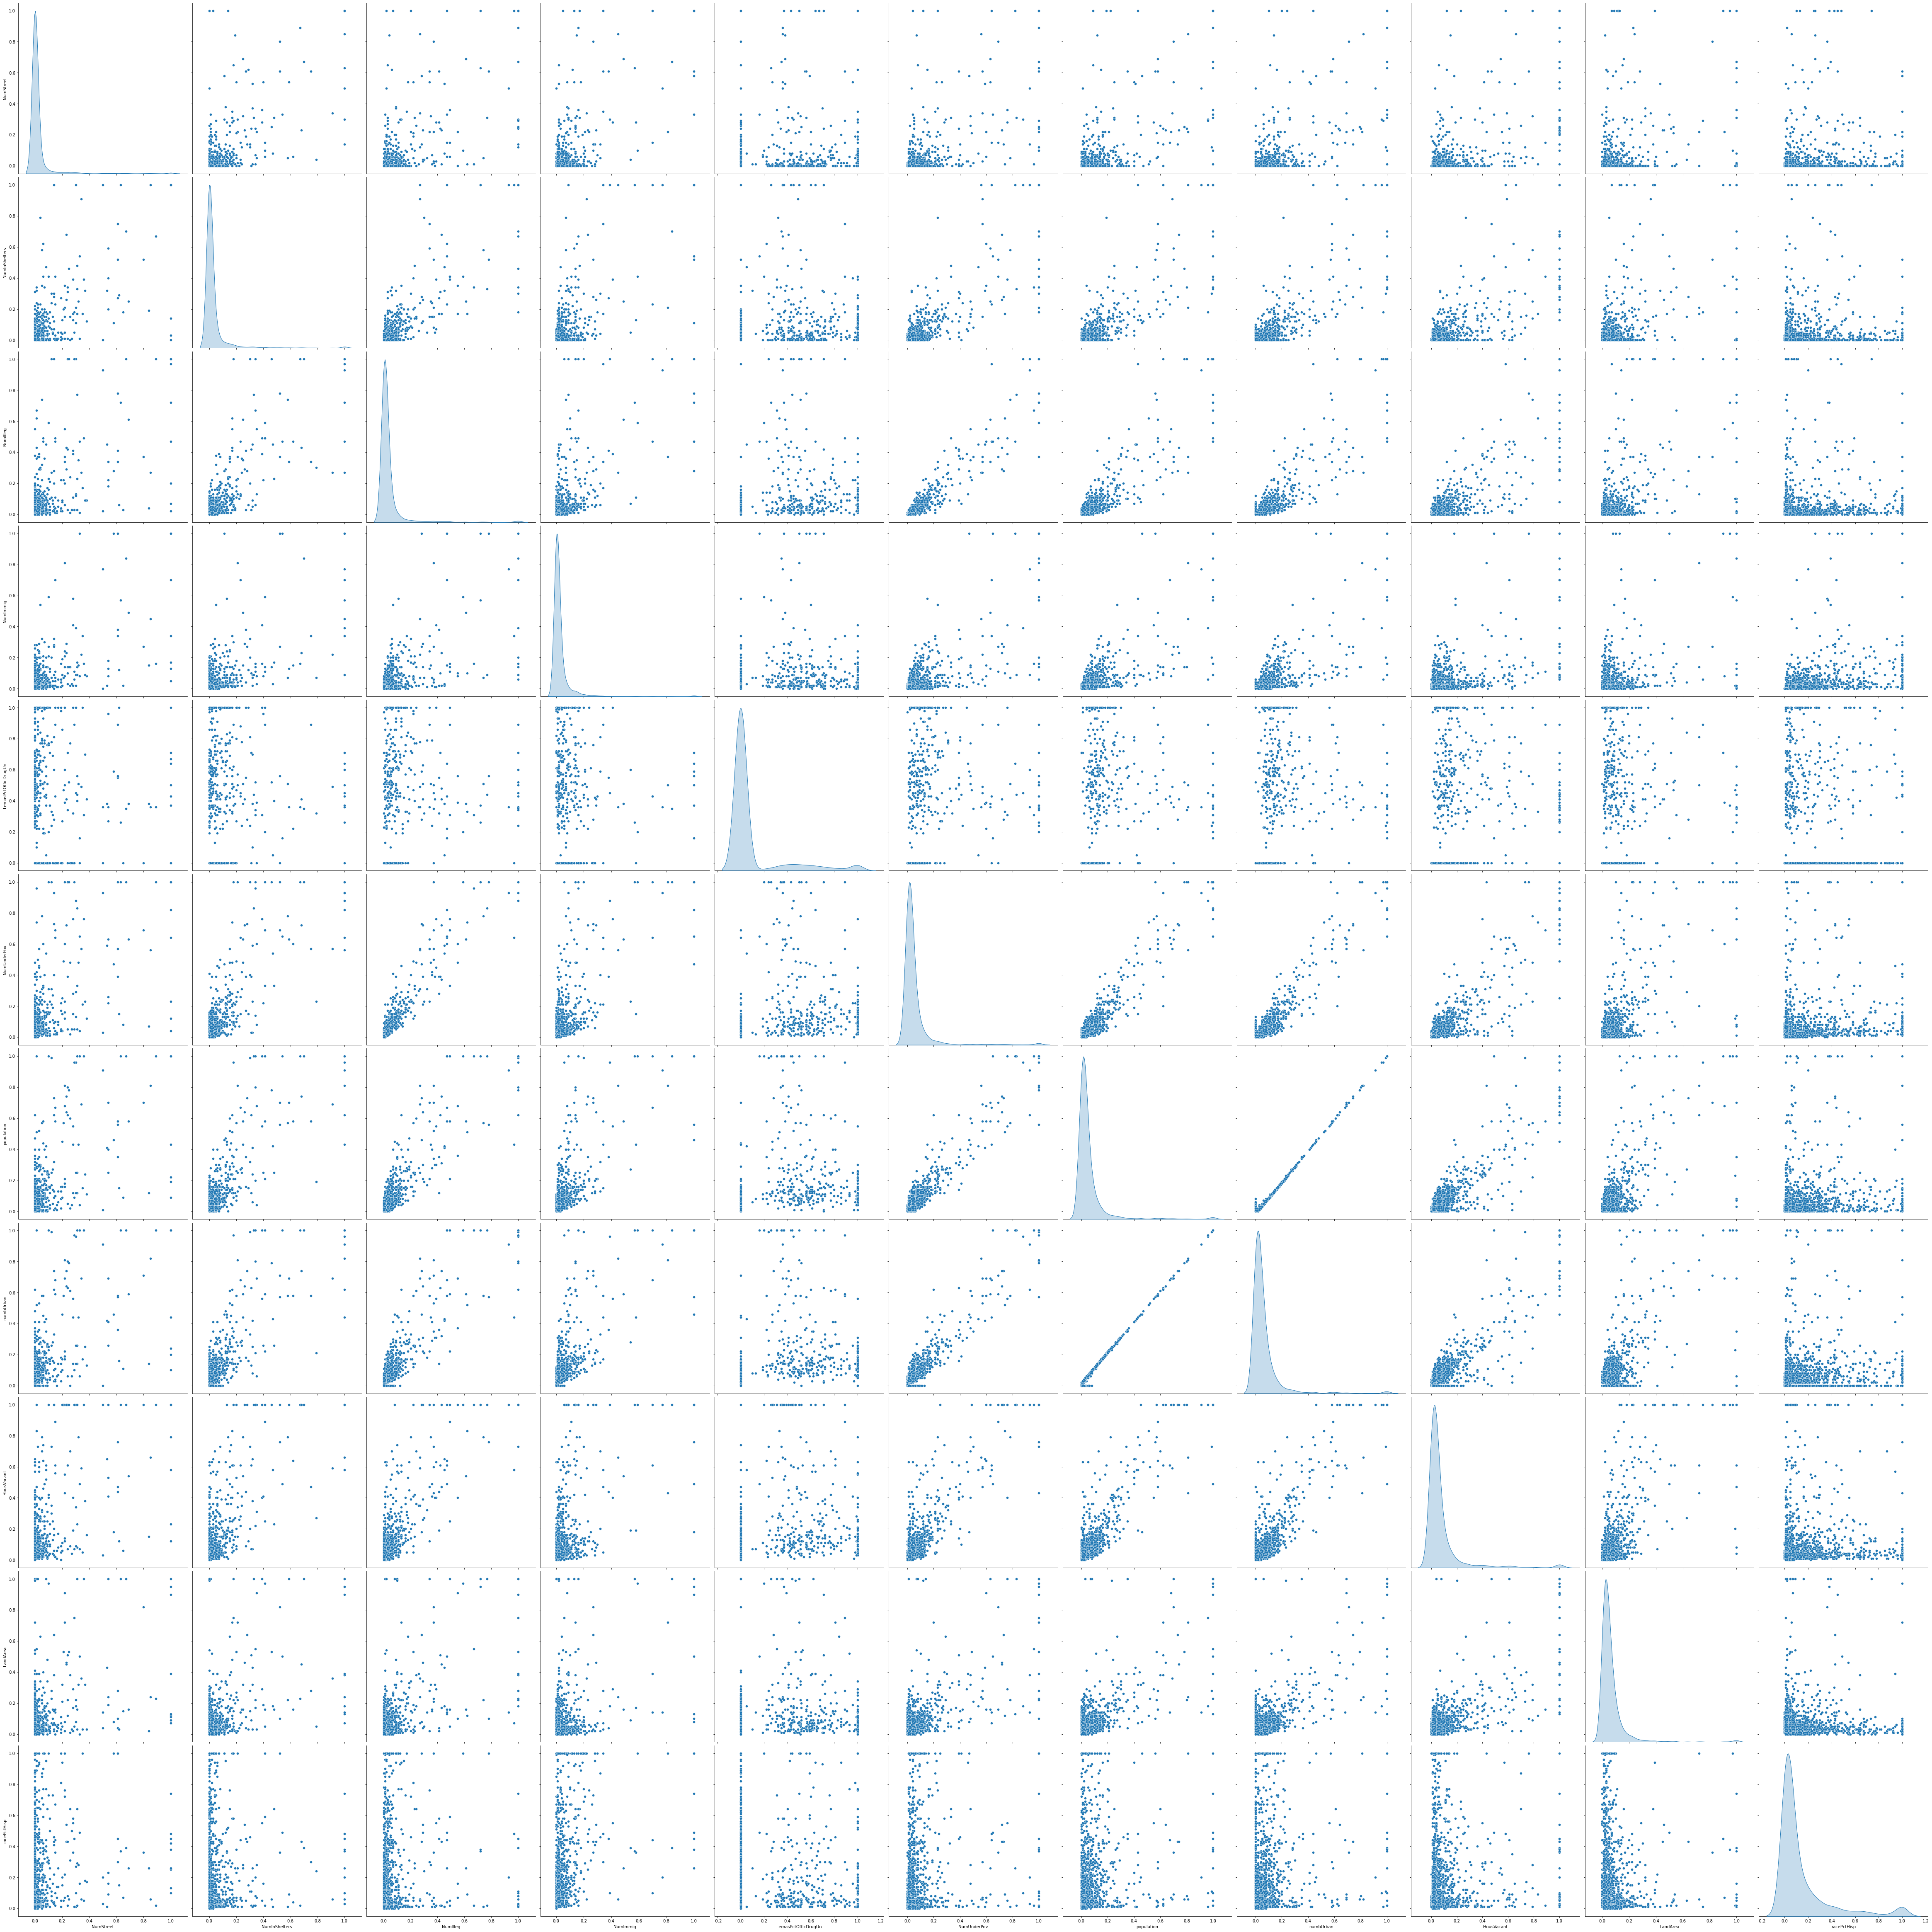

In [163]:
feature_num = int(128**(1/2))
sorted_cv = cv.sort_values(ascending=False)
sorted_cv[:feature_num]

highCV_features = ['NumStreet','NumInShelters','NumIlleg','NumImmig','LemasPctOfficDrugUn', 'NumUnderPov',
      'population','numbUrban','HousVacant','LandArea','racePctHisp']
highCV_X = X.loc[:, highCV_features]

# create scatter plot
fig = plt.figure()
sns.pairplot(highCV_X, height=6, diag_kind="kde")
plt.show()

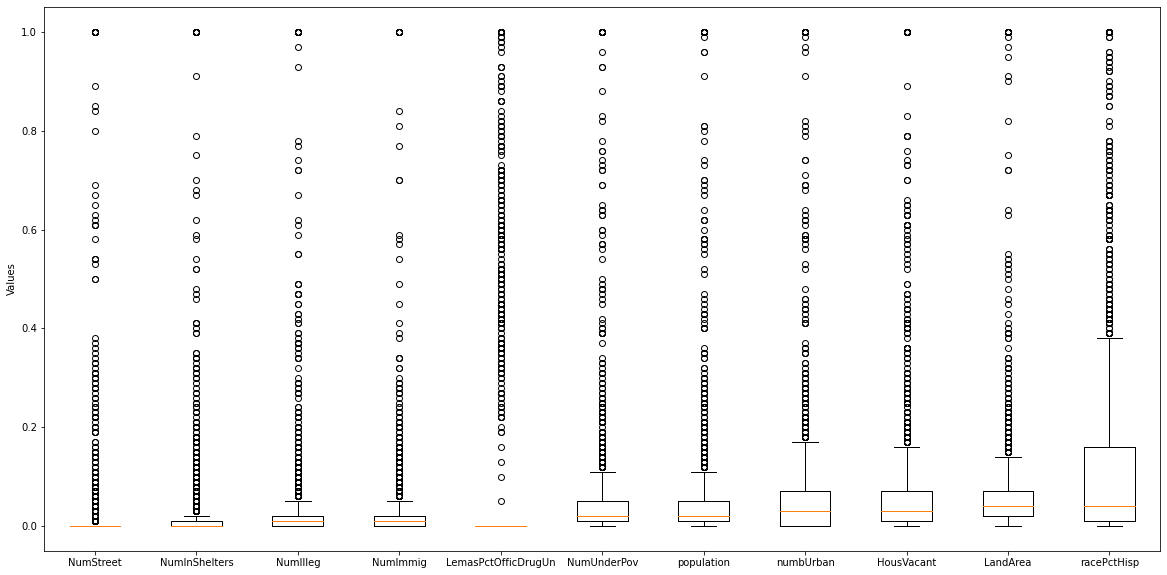


Conclusion:
Based on the scatter plots, we can tell that there are some features linearly correlated with the other like population & numbUrban, and numbUrban & NumUnderPov, but we cannot determine the significance of those.
    


In [179]:
# create box plot
fig = plt.figure(figsize=(20,10))
plt.boxplot(highCV_X)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11], highCV_features)
plt.ylabel('Values')
plt.show()

print('''
Conclusion:
Based on the scatter plots, we can tell that there are some features linearly correlated with the other like population & numbUrban, and numbUrban & NumUnderPov, but we cannot determine the significance of those.
    ''')

### (f) Fit a linear model

In [201]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
test_pred1 = lr.predict(X_test)
test_error1 = mean_squared_error(y_test,test_pred1)
print('The test error of the linear model:', test_error1)

The test error of the linear model: 0.7897255274315268


### (g) Fit a ridge regression model

In [331]:
from sklearn.linear_model import RidgeCV

# alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 2.3, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40,60,80,100]
alphas = 10**np.linspace(10,-2,100)*0.5
# alphas = [0.1, 1 , 10]
rr = RidgeCV(alphas=alphas, cv=5)
rr.fit(X_train, y_train)
test_pred2 = rr.predict(X_test)
test_error2 = mean_squared_error(y_test,test_pred2)
print('The test error of the ridge regression model:', test_error2)
alpha = rr.alpha_
# print(alpha)

The test error of the ridge regression model: 0.017602376551782168


### (h) Fit a LASSO model

In [346]:
from sklearn.linear_model import LassoCV

# alphas = 10**np.linspace(10,-2,100)*0.5
# lasso = LassoCV(alphas = alphas, cv=5, random_state=0)
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_train, y_train)
test_pred3 = lasso.predict(X_test)
test_error3 = mean_squared_error(y_test,test_pred3)
print('The test error of the LASSO model:', test_error3)

# lasso.coef_
var = X_train.iloc[:,lasso.coef_!=0].keys().tolist()
print("\nSelected variables:", var) #75 var

import warnings
warnings.filterwarnings('ignore')

The test error of the LASSO model: 0.01776331001785824

Selected variables: ['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn

In [282]:
# Fit a LASSO model with standardized4 features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# alphas = 10**np.linspace(10,-2,100)*0.5
# lasso_std = LassoCV(alphas=alphas,cv=5, random_state=0)

lasso_std = LassoCV(cv=5, random_state=0)
lasso_std.fit(X_train_std, y_train)
test_pred3_std = lasso_std.predict(X_test_std)
test_error3_std = mean_squared_error(y_test,test_pred3_std)
print('The test error of the LASSO model with standardized features:', test_error3_std)
var_std = X_train.iloc[:,lasso_std.coef_!=0].keys().tolist()
print("\nSelected variables:", var_std) #73 var

warnings.filterwarnings('ignore')

The test error of the LASSO model with standardized4 features: 0.017810499483270535

Selected variables: ['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec5', 'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn'

In [1]:
print("Compared the two test errors, the LASSO model has the smaller test error so it is better than the LASSO model with standardized features.")

Compared the two test errors, the LASSO model has the smaller test error so it is better than the LASSO model with standardized features.


### (i) Fit a PCR model

In [326]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from sklearn import model_selection

pca = PCA()
X_train_pca = pca.fit_transform(scale(X_train))
lr = LinearRegression()
n_components = range(1, X_train_pca.shape[1] + 1)
mse = []
for i in n_components:
    score = -1 * model_selection.cross_val_score(lr,
               X_train_pca[:,:i], 
               y_train, 
               cv=5, 
               scoring='neg_mean_squared_error').mean()
    mse.append((i, score))

# print(mse)
# plt.plot(mse)
# plt.xlabel('Number of principal components')
# plt.ylabel('MSE')

mse.sort(key = lambda a: a[1]) 
print("The optimal number of principal components with the smallest mse:", mse[0])

pca = PCA(n_components = 95)
X_train_pca = pca.fit_transform(scale(X_train))
X_test_pca = pca.fit_transform(scale(X_test))
lr = LinearRegression()
lr.fit(X_train_pca, y_train)
test_pred_pcr = lr.predict(X_test_pca)
test_error_pcr = mean_squared_error(y_test, test_pred_pcr)
print("Test error of the PCR model:", test_error_pcr)

## https://www.statology.org/principal-components-regression-in-python/ 

The optimal number of principal components with the smallest mse: (95, 0.019455164869318444)
Test error of the PCR model: 0.04642486239094019


### (j) Fit a boosting tree

In [390]:
import xgboost as xgb

alphas = [x * 0.1 for x in range(0, 101)]
ls = list()
for alpha in alphas:
    xgb_model = xgb.XGBRegressor(reg_alpha=alpha)
    mse = (model_selection.cross_val_score(xgb_model,X_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1).mean())**2
    ls.append((alpha, mse))
# print(ls)
ls.sort(key = lambda a: a[1]) 
print("The optimal alpha is", ls[0][0], "with the smallest mse", ls[0][1])

The optimal alpha is 3.5 with the smallest mse 0.009553733859522065
